# The logit transform

In [1]:
import numpy as np
from scipy.stats import norm, gaussian_kde, beta
import matplotlib.pyplot as plt


In [42]:
def linear_mix(p, max=100):
    return min(p/max, 1)

def quadratic_mix(p, max=100):
    return min((p/max)**2, 1)

def sigmoid_mix(p, smoothing=0.01):
    return (1 / (1 + np.exp(-p*smoothing)) - 1/2) * 2

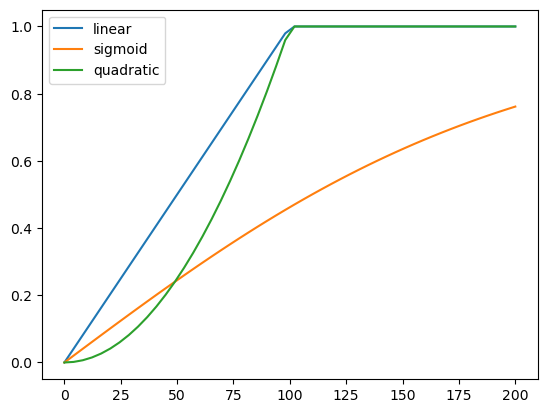

In [43]:
sizes = np.linspace(0, 200)
plt.plot(
    sizes,
    [linear_mix(s) for s in sizes],
    label='linear'
)
plt.plot(
    sizes,
    [sigmoid_mix(s) for s in sizes],
    label='sigmoid'
)
plt.plot(
    sizes,
    [quadratic_mix(s) for s in sizes],
    label='quadratic'
)

plt.legend()

In [398]:
def logit(x):
    return np.log(x / (1-x))

def logit_inv(x):
    return np.exp(x) / (1 + np.exp(x))

def derivative_logit(x):
    return 1/(x*(1-x))

def edge_adjustment(x, epsilon=0.001):
    return epsilon + (1-2*epsilon)*x

def gaussian_kernel(x, x_i, sigma, bandwidth):
    return norm.pdf(x, loc=x_i, scale=bandwidth*sigma) 

def gaussian_kernel_cdf(x, x_i, sigma, bandwidth):
    return norm.cdf(x, loc=x_i, scale=bandwidth*sigma) 

def transform_with_edge_adjustment(x, epsilon=0.001):
    return logit(edge_adjustment(x, epsilon))

def derivative_transform_with_edge_adjustment(x, epsilon=0.001):
    return (2*epsilon - 1) / ((2*epsilon*x - epsilon - x)*(2*epsilon*x - epsilon - x + 1))

def scott_bandwidth(data):
    """
    Compute the bandwidth using Scott's Rule of Thumb.
    """
    n = len(data)
    std_dev = np.std(data, ddof=1)  # Unbiased standard deviation
    bandwidth = np.power(n, -1 / 5) * std_dev
    return bandwidth

def silverman_bandwidth(data):
    """
    Compute the bandwidth using Silverman's Rule of Thumb.
    """
    n = len(data)
    std_dev = np.std(data, ddof=1)  # Unbiased standard deviation
    iqr = np.subtract(*np.percentile(data, [75, 25]))  # Interquartile range
    scale_factor = min(std_dev, iqr / 1.34)
    bandwidth = 0.9 * scale_factor * np.power(n, -1 / 5)
    return bandwidth

In [399]:
derivative_transform_with_edge_adjustment(0.5, epsilon=0), derivative_logit(0.5)

(4.0, 4.0)

# Two methods

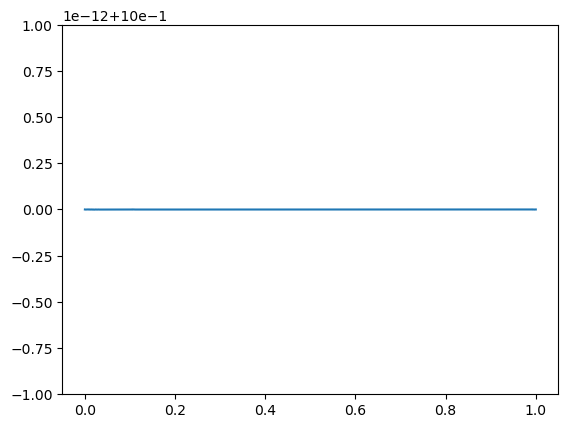

In [400]:
# Generate example bounded data
a = 1
b = 1
data = np.random.beta(a, b, size=1000)

plt.plot(
    np.linspace(0,1,1000),
    beta.pdf(np.linspace(0,1,1000), a, b)
)

In [401]:
bandwidth_method = 'scott'

## Logit

In [409]:
delta = 0.0001

transformed_data = transform_with_edge_adjustment(data, delta)

kde = gaussian_kde(transformed_data, bw_method=bandwidth_method)
h = kde.factor
sigma = transformed_data.std()

kernel_pdf_transformed = lambda x: np.mean(norm.pdf(x, loc=transformed_data[:, None], scale=h*sigma))
kernel_cdf_transformed = lambda x: np.mean(norm.cdf(x, loc=transformed_data[:, None], scale=h*sigma))

kernel_pdf_logit = lambda x: kernel_pdf_transformed(transform_with_edge_adjustment(x, delta)) * derivative_transform_with_edge_adjustment(x, delta)
kernel_cdf_logit = lambda x: kernel_cdf_transformed(transform_with_edge_adjustment(x, delta))

In [ ]:
delta = 0.0001

transformed_data = transform_with_edge_adjustment(data, delta)

kde = gaussian_kde(transformed_data, bw_method=bandwidth_method)
h = kde.factor
sigma = transformed_data.std()


def kernel_pdf_transformed(x):
    x = np.atleast_1d(x)  # Ensure x is an array
    pdf_values = np.mean(norm.pdf(x[:, None], loc=transformed_data, scale=h * sigma), axis=1)
    if pdf_values.size == 1:  # Check if the result is a single value
        return pdf_values.item()  # Convert single-element array to scalar
    return pdf_values

def kernel_cdf_transformed(x):
    x = np.atleast_1d(x)  # Ensure x is an array
    cdf_values = np.mean(norm.cdf(x[:, None], loc=transformed_data, scale=h * sigma), axis=1)
    if cdf_values.size == 1:  # Check if the result is a single value
        return cdf_values.item()  # Convert single-element array to scalar
    return cdf_values

def kernel_pdf_logit(x):
    x = np.atleast_1d(x)  # Ensure x is an array
    pdf_transform_values = kernel_pdf_transformed(transform_with_edge_adjustment(x, delta)) * derivative_transform_with_edge_adjustment(x, delta)
    if pdf_transform_values.shape[0] == 1: 
        return pdf_transform_values[0]
    return pdf_transform_values

def kernel_cdf_logit(x):
    x = np.atleast_1d(x)  # Ensure x is an array
    cdf_reflect_values = kernel_cdf_transformed(transform_with_edge_adjustment(x, delta))
    return cdf_reflect_values

In [435]:
kernel_cdf_logit(np.array([0.4, 0.5]))

array([0.39874047, 0.48653216])

## Reflection

In [410]:
kde_raw = gaussian_kde(data, bw_method=bandwidth_method)
h_raw = kde_raw.factor

sigma_raw = data.std()
kernel_pdf_raw = lambda x: np.mean(norm.pdf(x, loc=data[:, None], scale=h_raw*sigma_raw))
kernel_cdf_raw = lambda x: np.mean(norm.cdf(x, loc=data[:, None], scale=h_raw*sigma_raw))

kernel_pdf_reflect = lambda x: kernel_pdf_raw(x) + kernel_pdf_raw(-x) + kernel_pdf_raw(2-x)
kernel_cdf_reflect = lambda x: kernel_cdf_raw(x) - kernel_cdf_raw(-x) + 1 - kernel_cdf_raw(2-x)

## Plot

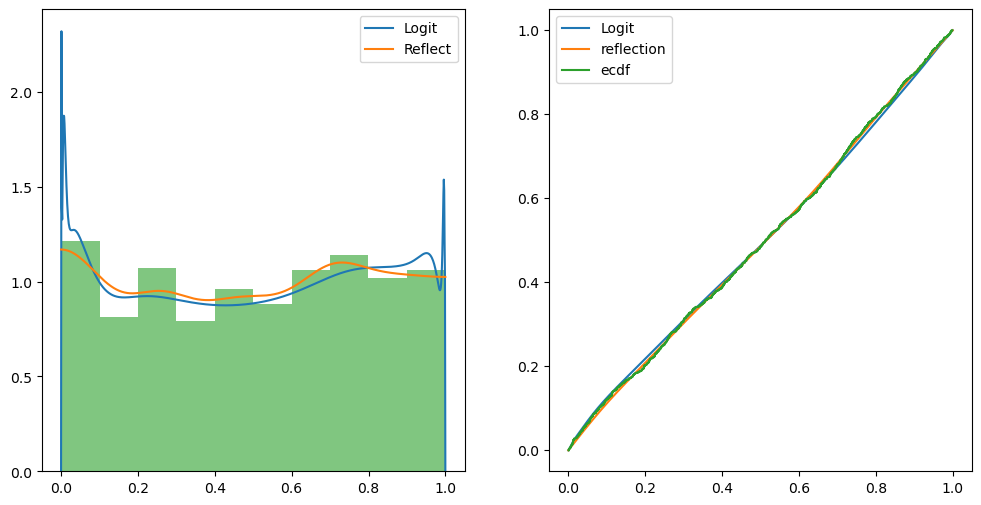

In [413]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
sorted_data = np.sort(data)
prange = np.linspace(0, 1, endpoint=True, num=1000) # Will raise a RuntimeWarning, caused by the logit transform. This can be fixed in practice.
axs[0].plot(
    prange,
    [kernel_pdf_logit(p) for p in prange],
    label='Logit'
)
axs[0].plot(
    prange,
    [kernel_pdf_reflect(p) for p in prange],
    label='Reflect'
)
axs[0].hist(data, density=True, alpha=0.6)
axs[0].legend()

# Calculate the empirical CDF
ecdf = np.arange(len(sorted_data)) / (len(sorted_data) - 1)

axs[1].plot(
    prange,
    [kernel_cdf_logit(p) for p in prange],
    label='Logit'
)
axs[1].plot(
    prange,
    [kernel_cdf_reflect(p) for p in prange],
    label='reflection'
)
axs[1].step(sorted_data, ecdf, label='ecdf')
axs[1].legend()

### Check derivatives

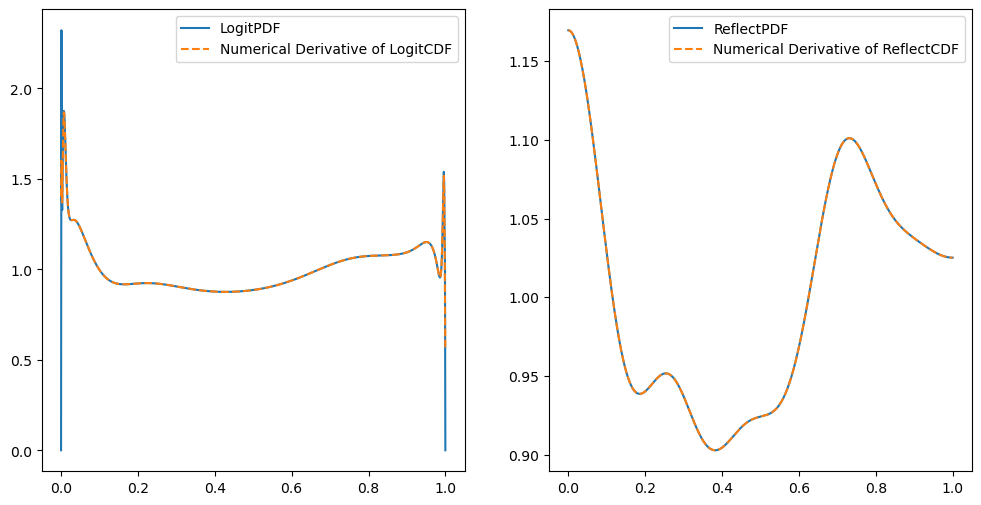

In [405]:
cdf_logit_vals = [kernel_cdf_logit(p) for p in prange]
numerical_pdf_logit = np.gradient(cdf_logit_vals, prange)

pdf_reflect_vals = [kernel_cdf_reflect(p) for p in prange]
numerical_pdf_reflect = np.gradient(pdf_reflect_vals, prange)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
axs[0].plot(prange, [kernel_pdf_logit(p) for p in prange], label='LogitPDF')
axs[0].plot(prange, numerical_pdf_logit, label="Numerical Derivative of LogitCDF", linestyle='--')
axs[0].legend()

axs[1].plot(prange, [kernel_pdf_reflect(p) for p in prange], label='ReflectPDF')
axs[1].plot(prange, numerical_pdf_reflect, label="Numerical Derivative of ReflectCDF", linestyle='--')
axs[1].legend()

### Check integrals

In [406]:
print(f'Integral of LogitPDF: {np.trapz([kernel_pdf_logit(p) for p in prange], prange)}') 
print(f'Integral of ReflectPDF: {np.trapz([kernel_pdf_reflect(p) for p in prange], prange)}')

Integral of LogitPDF: 0.9998091904060805
Integral of ReflectPDF: 1.0
